### 下載Fruits360資料集

In [1]:
import tensorflow as tf
import gc

url = 'https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip'
name = 'fruits360'
file = tf.keras.utils.get_file(name,url,extract=True)

   8192/Unknown - 0s 0us/step

In [2]:
import os

# 指定訓練資料夾目錄
training_path = os.path.sep.join(file.split(os.path.sep)[0:-1]+['Fruit-Images-Dataset-master','Training'])

# 指定測試資料夾目錄
test_path     = os.path.sep.join(file.split(os.path.sep)[0:-1]+['Fruit-Images-Dataset-master','Test'])

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from IPython.display import display
def show_model(model,figsize=(20,20)):
    a = plot_model(model,'models/' + model.name +'.png', show_shapes=True, dpi=300)
    display(a)
    return

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

# 訓練資料集
train_dataset = image_dataset_from_directory(training_path,batch_size=32,image_size=(100, 100),validation_split=0.1,shuffle=True,label_mode='categorical',seed=123,subset='training')

# 驗證資料集
validation_dataset = image_dataset_from_directory(training_path,batch_size=32,image_size=(100, 100),validation_split=0.1,shuffle=True,label_mode='categorical',seed=123,subset='validation')

#測試資料集
test_dataset = image_dataset_from_directory(test_path,batch_size=32,label_mode='categorical',image_size=(100, 100))

Found 67692 files belonging to 131 classes.
Using 60923 files for training.
Found 67692 files belonging to 131 classes.
Using 6769 files for validation.
Found 22688 files belonging to 131 classes.


In [5]:
import matplotlib.pyplot as plt
test_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>

### 定義卷積神經網路架構

In [6]:
vgg_base = keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(100, 100, 3))
vgg_base.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
], name='data_augmentation')

In [8]:
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.layers import Concatenate
def denseBlock(x,c,k):
  a = [x]
  for i in range(3):
    x = Conv2D(c,k,padding='same',activation='relu')(x)
    a.append(x)
    x = Concatenate()(a)
  return x 

In [9]:
inputs = keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(x)
x = denseBlock(x, 64, 3)
x = Conv2D(64, 3, 3, padding='same',activation='relu')(x)
x = layers.AveragePooling2D(2, padding='same')(x)
x = denseBlock(x, 128, 3)
x = Conv2D(128, 3, 3, padding='same',activation='relu')(x)
x = layers.AveragePooling2D(2, padding='same')(x)
x = denseBlock(x, 256, 3)
x = Conv2D(256, 3, 3, padding='same',activation='relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = denseBlock(x, 512, 3)
x = layers.MaxPooling2D(2, padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(131, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  0          ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 3)  400        ['data_augmentation[0][0]']      
 alization)                                                                                       
                                                                                              

### 訓練卷積神經網路

In [10]:
transfer_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='models/fruit_transfer_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

In [11]:
history = model.fit(train_dataset,epochs=10,validation_data=validation_dataset,callbacks=transfer_callbacks)

Epoch 1/10
1904/1904 [==============================] - ETA: 0s - loss: 2.3137 - accuracy: 0.3686
Epoch 1: val_loss improved from inf to 0.67970, saving model to models/fruit_transfer_model.keras
1904/1904 [==============================] - 263s 127ms/step - loss: 2.3137 - accuracy: 0.3686 - val_loss: 0.6797 - val_accuracy: 0.7871
Epoch 2/10
1904/1904 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.8067
Epoch 2: val_loss improved from 0.67970 to 0.24576, saving model to models/fruit_transfer_model.keras
1904/1904 [==============================] - 242s 127ms/step - loss: 0.5848 - accuracy: 0.8067 - val_loss: 0.2458 - val_accuracy: 0.9283
Epoch 3/10
1904/1904 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9058
Epoch 3: val_loss improved from 0.24576 to 0.18136, saving model to models/fruit_transfer_model.keras
1904/1904 [==============================] - 237s 125ms/step - loss: 0.2858 - accuracy: 0.9058 - val_loss: 0.1814 - val_accuracy: 

### 顯示訓練損失歷史曲線

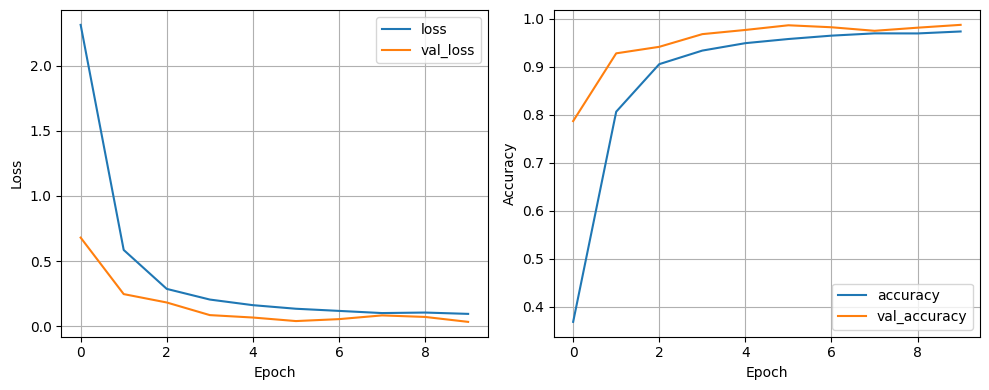

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 類神經網路架構圖

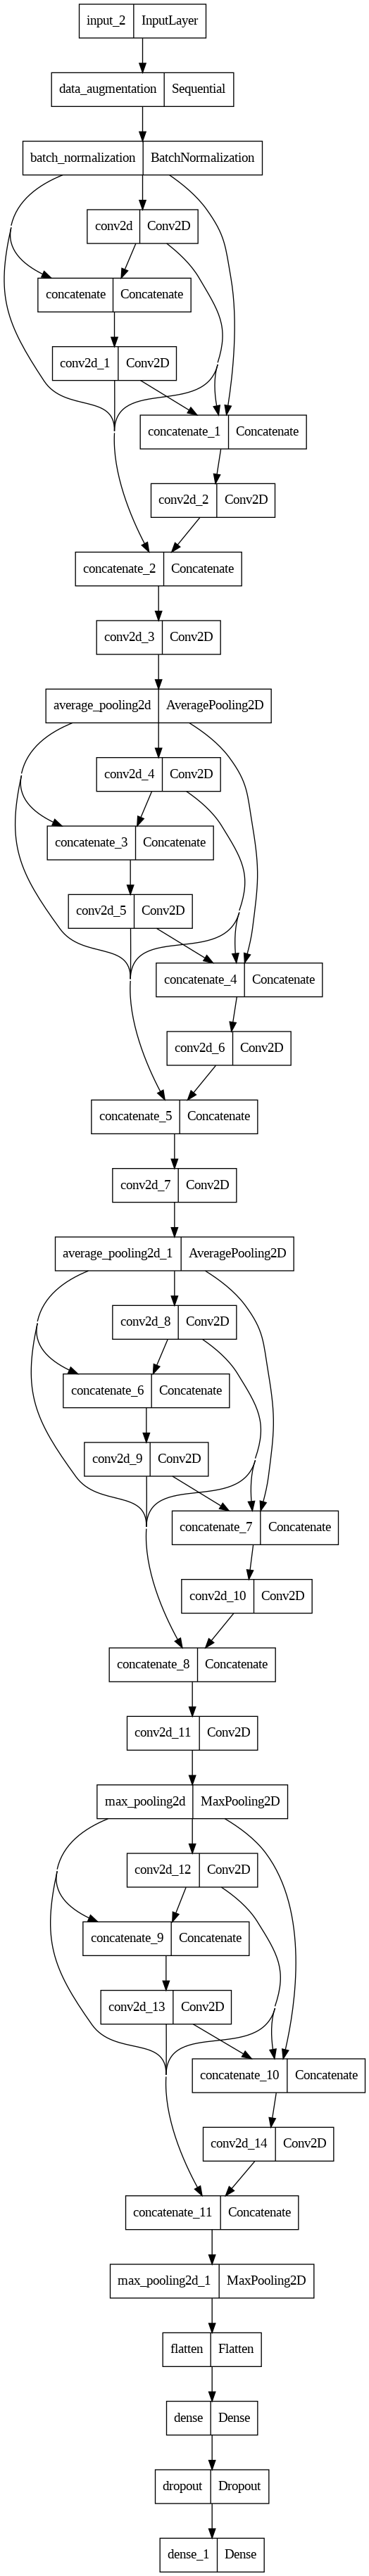

In [13]:
#類神經網路架構
tf.keras.utils.plot_model(model, to_file="neural_architecture1.png")

In [15]:
my_test_model = keras.models.load_model('models/fruit_transfer_model.keras')
test_loss, test_accuracy = my_test_model.evaluate(test_dataset)
print(f"test accuracy: {test_accuracy:.3f}")

709/709 [==============================] - 24s 33ms/step - loss: 0.2166 - accuracy: 0.9542
test accuracy: 0.954
